In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

sns.set_style('darkgrid')

# Part    1    ‑    Exploratory    data    analysis 

The    attached       logins.json       file     contains     (simulated)     timestamps    of    user     logins     in    a    particular  geographic     location.     Aggregate     these     login     counts    based    on    15­ minute     time     intervals,    and  visualize     and    describe     the     resulting     time     series    of     login     counts     in    ways     that    best     characterize     the  underlying    patterns     of     the    demand.     Please     report/illustrate     important     features    of     the    demand,  such     as    daily     cycles.     If     there     are     data     quality     issues,    please     report     them. 


In [2]:
df = pd.read_json("logins.json")
df["login_time"] = pd.to_datetime(df["login_time"])
df = df.set_index(df['login_time'])
df.head()

,login_time
login_time,
1970-01-01 20:13:18,1970-01-01 20:13:18
1970-01-01 20:16:10,1970-01-01 20:16:10
1970-01-01 20:16:37,1970-01-01 20:16:37
1970-01-01 20:16:36,1970-01-01 20:16:36
1970-01-01 20:26:21,1970-01-01 20:26:21


In [3]:
df.describe()

,login_time
count,93142
unique,92265
top,1970-02-12 11:16:53
freq,3
first,1970-01-01 20:12:16
last,1970-04-13 18:57:38


In [4]:
df['num'] = np.ones(len(df), dtype=int) # assign a value of 1 to each record
df.head()

,login_time,num
login_time,,
1970-01-01 20:13:18,1970-01-01 20:13:18,1
1970-01-01 20:16:10,1970-01-01 20:16:10,1
1970-01-01 20:16:37,1970-01-01 20:16:37,1
1970-01-01 20:16:36,1970-01-01 20:16:36,1
1970-01-01 20:26:21,1970-01-01 20:26:21,1


In [5]:
# aggregate logins by 15 minute time intervals

time = df.resample('15T').sum()
time.head(10)

,num
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1
1970-01-01 21:15:00,4
1970-01-01 21:30:00,0
1970-01-01 21:45:00,4
1970-01-01 22:00:00,9


__The most amount of logins, 73, occured on March 1, 1970 between 4:30 P.M and 4:45 P.M.__

In [6]:
time[time.num == time.num.max()] 

,num
login_time,
1970-03-01 04:30:00,73


__There seems to be an underlying pattern or rhythm in the data occuring over time, however, several spikes of logins seem to be random and of different length each time.__

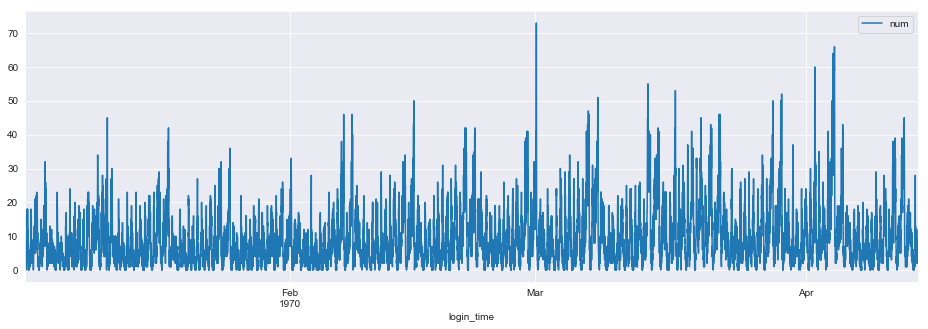

In [7]:
time.plot(figsize=[16,5])

__When we look at the components of the time series, we see seasonality occur at a scale of 24 hours (nice cyclical pattern) and an upward trend after February, peaking around Mid March before slowing decreasing, which is in line with the number of spikes that occur after February versus before February.__

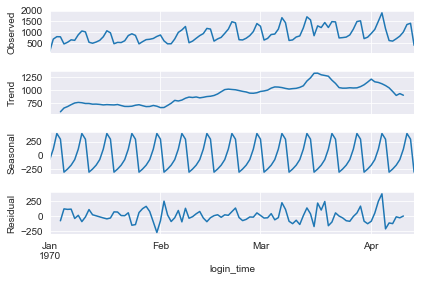

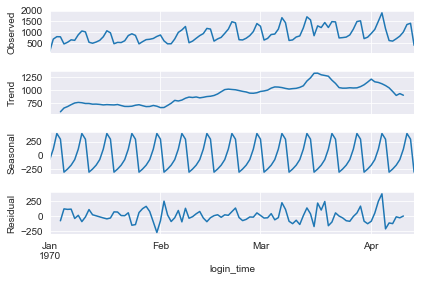

In [8]:
result = seasonal_decompose(df.resample('24H').sum())
result.plot()

__Overall, on weekdays, the number of logins progressively increases as the week goes on. Weekends are when the most logins occur, especially on Saturdays.__ 

Text(0, 0.5, 'num of logins')

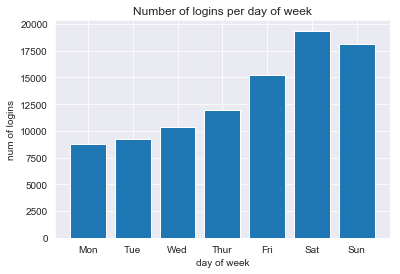

In [9]:
df['dow'] = df['login_time'].dt.dayofweek
day = df.groupby(['dow']).sum()
plt.bar(['Mon','Tue','Wed','Thur','Fri','Sat','Sun'], day['num'])
plt.title('Number of logins per day of week')
plt.xlabel('day of week')
plt.ylabel('num of logins')

__Now we take a look at the average number of logins per 15 minute interval based on day of week.__

In [10]:
time['dom'] = time.index.day
time['dow'] = time.index.dayofweek
time['month'] = time.index.month
time['hour'] = time.index.hour
time['minute'] = time.index.minute
time.head()

,num,dom,dow,month,hour,minute
login_time,,,,,,
1970-01-01 20:00:00,2,1,3,1,20,0
1970-01-01 20:15:00,6,1,3,1,20,15
1970-01-01 20:30:00,9,1,3,1,20,30
1970-01-01 20:45:00,7,1,3,1,20,45
1970-01-01 21:00:00,1,1,3,1,21,0


__Divide the number of logins per 15 minute interval by the total number of that specific interval.__

In [11]:
distrib = time.groupby(['dow','hour','minute']).sum() / time.groupby(['dow','hour','minute']).count()
distrib = distrib.reset_index()
distrib.head(10)

,dow,hour,minute,num,dom,month
0,0,0,0,8.400000,14.066667,2.333333
1,0,0,15,9.333333,14.066667,2.333333
2,0,0,30,9.600000,14.066667,2.333333
3,0,0,45,8.066667,14.066667,2.333333
4,0,1,0,7.266667,14.066667,2.333333
5,0,1,15,7.200000,14.066667,2.333333
6,0,1,30,7.000000,14.066667,2.333333
7,0,1,45,6.133333,14.066667,2.333333
8,0,2,0,6.066667,14.066667,2.333333
9,0,2,15,4.666667,14.066667,2.333333


__With the exception of weekends, the average number of logins, from 12:00 A.M, decreases until mid day 10:00 A.M to 1:00 P.M. for which it spikes. After 1:00 P.M., the average number of logins decrease until late 8:00 P.M to 12:00 A.M, where it increases once again. Saturday and Sunday have a relatively high average number of logins during late night to early morning then decreases heavily unitl about 1:00, where it remains steady unitl midnight.__

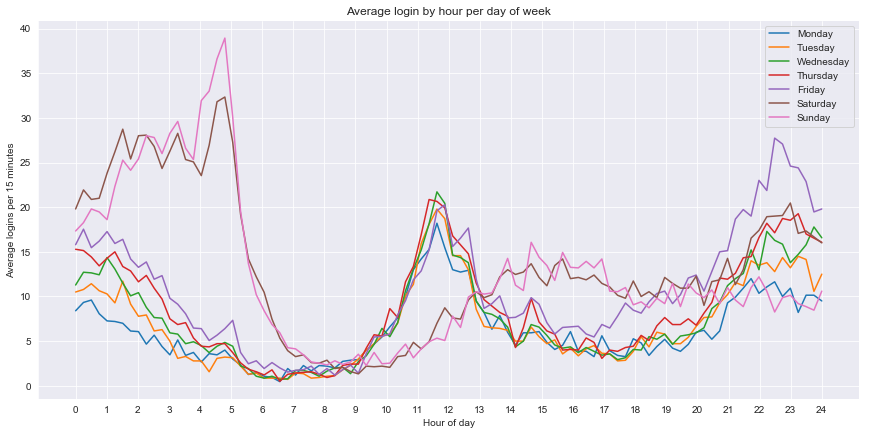

In [12]:
g = sns.FacetGrid(distrib[['dow', 'num']],hue='dow',height=6,aspect=2)
g.map(plt.plot, 'num')

plt.legend(labels=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
plt.xlabel('Hour of day')
plt.ylabel('Average logins per 15 minutes')
plt.title('Average login by hour per day of week')
_ = plt.xticks((pd.Series(range(0,25)) * (95 / 24)),pd.Series(range(0,25)))

# Part    2    ‑    Experiment    and    metrics    design 

The    neighboring     cities    of    Gotham    and    Metropolis    have     complementary     circadian     rhythms:     on  weekdays,    Ultimate    Gotham     is    most     active    at    night,    and    Ultimate    Metropolis     is    most    active  during     the    day.    On    weekends,     there     is     reasonable    activity     in    both     cities.    However,    a     toll    bridge,     with     a     two  ­way     toll,    between     the     two     cities     causes    driver    partners     to     tend  to    be    exclusive     to    each     city.     The     Ultimate    managers    of     city    operations     for     the     two     cities    have  proposed    an    experiment     to     encourage    driver    partners     to    be    available     in    both     cities,    by  reimbursing    all     toll     costs.  

1. What    would     you     choose     as     the     key    measure    of     success    of     this    experiment     in  encouraging    driver     partners     to     serve    both     cities,    and    why    would     you     choose     this    metric?  

__The key measure of success I would choose for this experiment would be the ratio of drivers from one city that serve the other city. I would measure, on a daily basis, the number of drivers from Metropolis that served Gotham, and the number of drivers from Gotham that served Metropolis, as ideally, we would want close to 50% of the drivers from Metropolis to serve Gotham, and vice versa.__

2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:

       a. how you will implement the experiment

__We could implement a sort of experiment similar to A/B testing, in which we would encourage drivers of Metropolis to serve in Gotham, and provide toll reimbursements to those drivers, and not provide any encouragement and incentives for drivers of Gotham. We would record what ratio of drivers from Metropolis drove to Gotham and measure the ratio of drivers from Gotham who drove to Metropolis on a daily basis for maybe a few months or a year.__ 

        b. what statistical test(s) you will conduct to verify the significance of the observation

__We would use hypothesis testing, specifically difference in the sample means, a two tailed t test, where the null hypothesis states that the mean ratio of drivers from Metropolis that serve Gotham is equal to the mean ratio of drivers from Gotham that serve Metropolis, and the alternative is if the means are not equal.__

      c. how you would interpret the results and provide recommendations to the city operations team along with any caveats.

__Ideally, we want the mean ratio of the drivers from Metropolis that serve Gotham to be greater (because they were encouraged and incentivized) than the ratio of drivers from Gotham that served Metropolis. If the t-stat of the Metropolis drivers that served Gotham is positive and not close to zero, indicating that p-val < 0.05 and reject the null hpyothesis, then the incentivization may be the appropriate method of encouraging drivers from both cities to serve the other, and implement it for Gotham drivers. However, if the p-val > 0.05, then the incentivization might not be the method, and another method should be experimented on.__ 

# Part    3    ‑    Predictive     modeling

Ultimate     is     interested     in     predicting     rider     retention.    To    help    explore     this    question,    we    have  provided     a     sample    dataset     of     a     cohort    of    users    who     signed    up     for    an    Ultimate    account     in 
January    2014.    The     data    was    pulled     several    months     later;    we     consider    a    user     retained     if     they  were     “active”     (i.e.     took    a     trip)     in     the     preceding    30    days.    We     would     like     you     to    use     this    data     set     to    help    understand    what     factors    are     the    best    predictors  for     retention,    and    offer     suggestions     to     operationalize     those     insights     to    help    Ultimate.    The    data     is     in     the    attached     file     ultimate_data_challenge.json.    See    below     for    a    detailed  description     of     the    dataset.     Please     include    any     code     you    wrote     for     the    analysis    and    delete     the  dataset    when     you    have     finished     with     the     challenge.   

Data    description  
● city:       city     this    user     signed     up     in  
● phone:      primary    device     for     this    user  
● signup_date:      date     of     account     registration;     in     the     form     ‘YYYY MM DD’  
● last_trip_date:       the     last     time     this    user     completed    a     trip;     in     the     form     ‘YYYY MM DD’  
● avg_dist:       the    average     distance     in    miles    per     trip     taken     in     the     first    30    days    after     signup  
● avg_rating_by_driver:       the     rider’s    average     rating    over    all    of     their     trips  
● avg_rating_of_driver:       the     rider’s    average     rating    of     their    drivers    over    all    of     their     trips  
● surge_pct:       the    percent     of     trips     taken    with     surge    multiplier    >    1  
● avg_surge:       The    average     surge    multiplier    over    all    of     this    user’s     trips  
● trips_in_first_30_days:       the     number    of     trips     this    user     took     in     the     first    30    days    after  signing    up   
● ultimate_black_user:       TRUE     if     the    user     took    an    Ultimate    Black     in     their     first    30    days;  FALSE    otherwise  
● weekday_pct:       the     percent     of     the    user’s     trips    occurring    during    a    weekday  

# Perform    any     cleaning,     exploratory    analysis,    and/or     visualizations     to    use     the    provided  data     for     this    analysis.    What  fraction     of     the    observed     users    were     retained?

In [46]:
with open('ultimate_data_challenge.json') as f:
    data = json.load(f)

df = pd.DataFrame(data)
df

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4
5,10.56,5.0,3.5,1.00,Winterfell,2014-06-06,iPhone,2014-01-09,0.0,2,True,100.0
6,3.95,4.0,NaN,1.00,Astapor,2014-01-25,Android,2014-01-24,0.0,1,False,100.0
7,2.04,5.0,5.0,1.00,Winterfell,2014-01-29,iPhone,2014-01-28,0.0,2,False,100.0
8,4.36,5.0,4.5,1.00,Winterfell,2014-02-01,Android,2014-01-21,0.0,2,False,100.0
9,2.37,5.0,NaN,1.00,Winterfell,2014-01-05,Android,2014-01-03,0.0,1,False,0.0


In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


__1. Fill in missing values from avg rating based on mean avg rating given to and by the drivers.__

In [48]:
df.avg_rating_by_driver.fillna(df['avg_rating_by_driver'].mean(), inplace=True)
df.avg_rating_of_driver.fillna(df['avg_rating_of_driver'].mean(), inplace=True)
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49604 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  49604 non-null float64
avg_rating_by_driver      49604 non-null float64
avg_rating_of_driver      49604 non-null float64
avg_surge                 49604 non-null float64
city                      49604 non-null object
last_trip_date            49604 non-null object
phone                     49604 non-null object
signup_date               49604 non-null object
surge_pct                 49604 non-null float64
trips_in_first_30_days    49604 non-null int64
ultimate_black_user       49604 non-null bool
weekday_pct               49604 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.6+ MB


In [49]:
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])
df['signup_date'] = pd.to_datetime(df['signup_date'])

C:\Users\dgoka\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\dgoka\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


__2. Because the user is considered retained if they took a trip in the preceding 30 days, we sort the df by last trip date, for which the most recent date is July 1, 2014, the user is considered retained if they took at trip after June 1, 2014. A response variable is created, in which a value of 1 is given if the user is retained, and 0 otherwise.__

In [50]:
df.sort_values(by=['last_trip_date'], ascending = False).head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
6356,3.51,4.5,3.8,1.09,King's Landing,2014-07-01,iPhone,2014-01-04,11.8,0,False,64.7
9491,5.00,5.0,4.7,1.38,Astapor,2014-07-01,iPhone,2014-01-19,50.0,0,False,50.0
37021,5.56,4.9,3.5,1.36,Winterfell,2014-07-01,iPhone,2014-01-05,44.4,1,True,55.6
9439,1.39,5.0,5.0,1.00,Astapor,2014-07-01,Android,2014-01-27,0.0,0,False,100.0
42346,6.19,4.7,5.0,1.00,Winterfell,2014-07-01,iPhone,2014-01-28,0.0,5,False,75.0


In [51]:
df['retained'] = (df.last_trip_date > '2014-06-01')*1
df.head()

C:\Users\dgoka\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,retained
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,1
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,1
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4,0


__3. Users from King's Landing are much more retained than users from Astapor and Winterfell, higher retention ratio for users with IPhones than with Androids, 50% of users who took Ultimate Black were retained.__

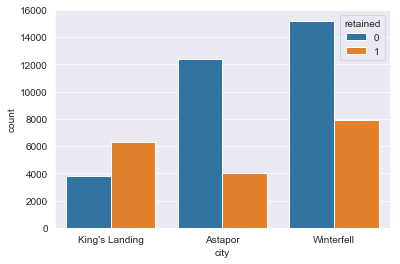

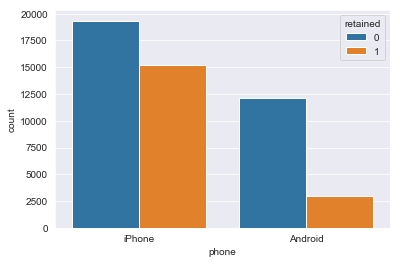

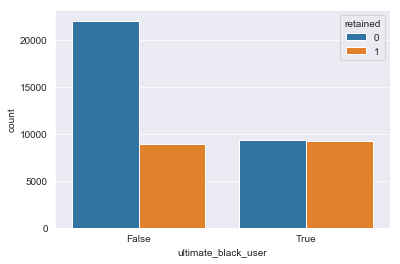

In [52]:
sns.countplot(x='city', hue='retained', data = df)
plt.show()
sns.countplot(x='phone', hue='retained',data = df)
plt.show()
sns.countplot(x='ultimate_black_user',hue='retained',data = df)
plt.show()

__4. Looking at the relationships between the numerical features and whether the user was retained or not:__
        
   __a. Not much difference between average distance in miles per trip between retained users and not retained users.__
       
   __b. Avg rating by driver slightly lower in retained users than not retained users.__
       
   __c.  Avg rating of driver slightly lower in retained users than not retained users.__
       
   __d. Percentage of trips taken with surge multiplier > 1 slightly higher in retained users than not.__ 
       
   __e. Average surge multiplier slightly higher in retained users than not.__ 
       
   __f. Retained users were slightly higher in the number of trips taken withim the first 30 days after signups, than non-retained users.__
       
   __g. Little difference in the percentage of of trips occuring on a weekeday between retained and non-retained users, even though wider distribution of percentages in non-retained users.__

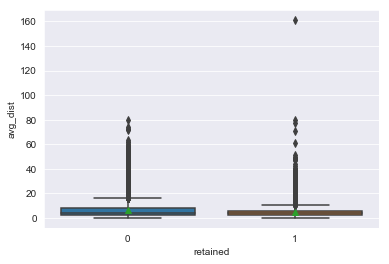

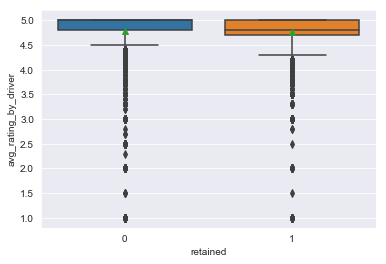

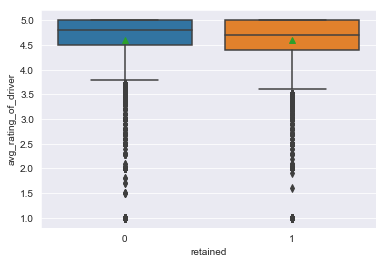

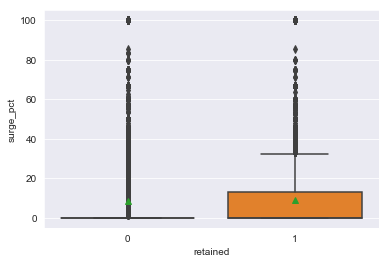

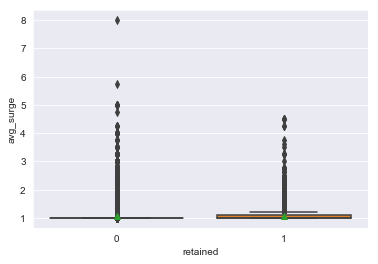

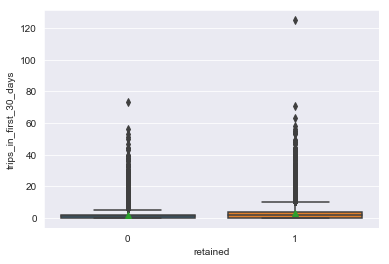

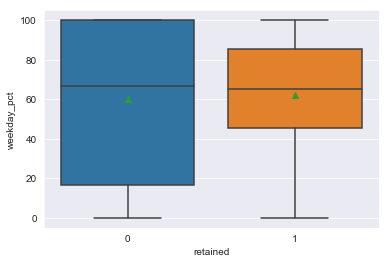

In [70]:
num_feat = ["avg_dist", "avg_rating_by_driver","avg_rating_of_driver", "surge_pct","avg_surge","trips_in_first_30_days","weekday_pct"]


for feat in num_feat:
    plt.figure()
    sns.boxplot(x='retained', y=feat, data=df, showmeans=True)

__5. Some amount of correlation between whether the user took an ultimate black and retention, as well as, trips in the first 30 days and retention. Avg surge and surge pct will be monitored for multicollinearity.__

Text(0.5, 1.0, 'Correlation heatmap between features')

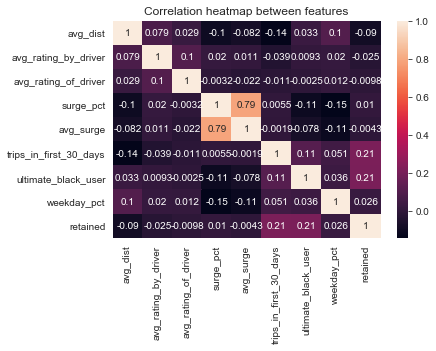

In [53]:
sns.heatmap(df[["avg_dist", "avg_rating_by_driver","avg_rating_of_driver", "surge_pct","avg_surge","trips_in_first_30_days", "ultimate_black_user","weekday_pct", "retained"]].corr(), annot=True)
plt.title("Correlation heatmap between features")

__6. 18671 users out of 49604 users were retained, or 38%__

In [56]:
perc = round(len(df[df.last_trip_date >= '2014-06-01']) / len(df), 2) * 100
print("The percentage of users retained was " + str(perc) + "%")

The percentage of users retained was 38.0%


# Build    a    predictive     model     to     help    Ultimate    determine    whether    or    not    a    user    will    be    active  in     their    6th    month     on     the     system.    Discuss    why     you     chose     your    approach,    what  alternatives     you     considered,     and    any     concerns     you    have.    How     valid     is     your    model?  Include    any     key     indicators    of     model    performance. 

__Pre-processing__

__1. Drop the unnecessary datetime features, create the dummy columns for the categorical features, and split the dataset into a training and test set.__

In [25]:
df = df.drop(['last_trip_date', 'signup_date'], axis=1)
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,phone,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,retained
0,3.67,5.0,4.7,1.10,King's Landing,iPhone,15.4,4,True,46.2,1
1,8.26,5.0,5.0,1.00,Astapor,Android,0.0,0,False,50.0,0
2,0.77,5.0,4.3,1.00,Astapor,iPhone,0.0,3,False,100.0,0
3,2.36,4.9,4.6,1.14,King's Landing,iPhone,20.0,9,True,80.0,1
4,3.13,4.9,4.4,1.19,Winterfell,Android,11.8,14,False,82.4,0


In [26]:
from sklearn.model_selection import train_test_split

df = pd.get_dummies(df, drop_first=True)

# Create arrays for the features and the response variable
y = df['retained'].values
X = df.drop('retained', axis=1).values

# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42, stratify=y)

df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,retained,city_King's Landing,city_Winterfell,phone_iPhone
0,3.67,5.0,4.7,1.10,15.4,4,True,46.2,1,1,0,1
1,8.26,5.0,5.0,1.00,0.0,0,False,50.0,0,0,0,0
2,0.77,5.0,4.3,1.00,0.0,3,False,100.0,0,0,0,1
3,2.36,4.9,4.6,1.14,20.0,9,True,80.0,1,1,0,1
4,3.13,4.9,4.4,1.19,11.8,14,False,82.4,0,0,1,0


__2. Initially, logistic regression and a decision tree were implemented to fit the training data, for which the best parameters were determined using GridSearchCV, and evaluated using the test dataset. The decision tree performed better than the logisitic regression, accuracy of 75% compared to LR's accuracy of 72%, because the decision tree may capture some of the nonlinear relationships between the independent variables and dependent variable.__

__Logistic Regression__

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

param_grid = {'penalty' : ['l1','l2'], 'C' : [0.001,0.01,0.1,1,10,100]}

gs = GridSearchCV(LogisticRegression(), param_grid, verbose=1, cv=3, n_jobs=-1)
gs_results = gs.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:   15.5s finished
C:\Users\dgoka\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [39]:
print("Best Parameters:", gs_results.best_params_)
print("Best Score:", gs.best_score_)
print("Best Estimator:", gs.best_estimator_)
print()
print("Test set accuracy:", gs.score(X_test, y_test))

Best Parameters: {'C': 0.01, 'penalty': 'l1'}
Best Score: 0.7261043771892246
Best Estimator: LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

Test set accuracy: 0.724322144945066


__Decision Tree__

In [40]:
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import randint

param_dist = {"max_depth": [3,2,1, None],
              "max_features": [5,6,7],
              "min_samples_leaf": [5,6,7],
              "criterion": ["gini", "entropy"]}

gs = GridSearchCV(DecisionTreeClassifier(), param_dist, verbose=1, cv=3, n_jobs=-1)
gs_results = gs.fit(X_train, y_train)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed:   25.5s finished


In [41]:
print("Best Parameters:", gs_results.best_params_)
print("Best Score:", gs.best_score_)
print("Best Estimator:", gs.best_estimator_)
print()
print("Test set accuracy:", gs.score(X_test, y_test))

Best Parameters: {'criterion': 'gini', 'max_depth': None, 'max_features': 5, 'min_samples_leaf': 7}
Best Score: 0.7522868734722677
Best Estimator: DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=5, max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=7,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

Test set accuracy: 0.7598024392702348


__3. Because the decision tree performed better than logisitic regression, we implement RandomForestClassifier, a commitee of decision trees, which would always be more accurate than it's individuals constituents, but much more computationally expensive to run. Again the best parameters are determined using GridSearchCV on the training data, and the model is evaluated using the test set, for which it performed better than the decision tree, with an accuracy of 79%.__

__Random Forest__

In [31]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [60, 80],
    'max_features': [1, 2],
    'min_samples_leaf': [5, 6, 7],
    'min_samples_split': [12, 14, 16],
    'n_estimators': [300, 500]
}

In [32]:
from sklearn.ensemble import RandomForestClassifier

rf = GridSearchCV(RandomForestClassifier(), param_grid, cv = 3, verbose=1, n_jobs = -1)
rf_results = rf.fit(X_train, y_train)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 12.3min
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed: 14.0min finished


In [37]:
print("Best Parameters:", rf_results.best_params_)
print("Best Score:", rf.best_score_)
print("Best Estimator:", rf.best_estimator_)
print()
print("Test set accuracy:", rf.score(X_test, y_test))

Best Parameters: {'bootstrap': True, 'max_depth': 80, 'max_features': 2, 'min_samples_leaf': 7, 'min_samples_split': 12, 'n_estimators': 300}
Best Score: 0.7896580399667363
Best Estimator: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=80, max_features=2, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=7, min_samples_split=12,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Test set accuracy: 0.7902429190605785


__4. Feature importance is built into the RandomForestClassifer, for the which the results show that the average ratings given by the driver to the user, amount of rides taken on the weekdays, and whether the user was from King's Landing or not, were the top three important features to accurately predict whether the user was retained or not.__

__Feature Importance__

In [34]:
rf_mod = RandomForestClassifier(bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=16, n_estimators=500)

rf_mod.fit(X_train, y_train)
rf_mod.feature_importances_

array([0.11578762, 0.15073512, 0.05282367, 0.08228347, 0.11656143,
       0.07637254, 0.05777086, 0.13246436, 0.12460326, 0.01712727,
       0.07347038])

In [35]:
features = df.drop("retained",axis=1).columns
feat_df = pd.DataFrame(features, columns=['feature'])
feat_df['score'] = rf_mod.feature_importances_
feat_df.sort_values('score', ascending=False)

,feature,score
1,avg_rating_by_driver,0.150735
7,weekday_pct,0.132464
8,city_King's Landing,0.124603
4,surge_pct,0.116561
0,avg_dist,0.115788
3,avg_surge,0.082283
5,trips_in_first_30_days,0.076373
10,phone_iPhone,0.073470
6,ultimate_black_user,0.057771
2,avg_rating_of_driver,0.052824


# Briefly    discuss    how     Ultimate     might     leverage     the     insights    gained     from     the    model     to  improve     its     long­  term     rider     retention     (again,    a     few     sentences    will     suffice).

# __Insights and Recommendations__

__Based on the EDA, modeling and feature importances for the best model: RandomForestClassifier.__
   
   __1. Even though the RandomForestClassifier performed better than a single Decision Tree (79% over 75%), Ultimate should be aware of the computational power it takes to run, and decide whether it would be time effective for a slightly for accurate model.__ 
   
   __2. Ultimate should encourage drivers to continue to rate users, as users with more positive ratings tend to become retained.__
   
   __3. Provide incentives for users to ride during the weekday, as it will more likely lead to a retained user.__
   
   __4. Users from King's Landing are retained more that users from Winterfell and Astapor, so its important to understand why users from King's Landing tend to keep riding with Ultimate, either through surveying or polling users from there, and try to use their opinions and reasons to encourage users from Astapor and Winterfell to continue riding with Ultimate with incentives and discounts.__
   
   __5. Approximately 50% of users were retained for users who took an Ultimate Black in their first 30 days, so Ultimate should also encourage and incentivize users to take Ultimate Black.__ 
   
   __6. It looks like the device the user uses to ride doesn't affect their retention, so A/B testing should be implemented on Ultimate's apps for Iphone and Android to test whether users click on more or use Ultimate's app, which would lead to more users being retained.__